### Packages + Configuration

In [1]:
# 1. Packages
import os
import netCDF4
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# 2. Configuration
year = 2001
variable = "2m_temperature"
day = 0

# 3. Load high quality image 
in_dir = Path.cwd()
in_path = in_dir / "input_raw" / f"{year}.nc"
with netCDF4.Dataset(in_path, "r") as f:
    HR = f.variables[variable][day, :, :]

### Generating input + Plot

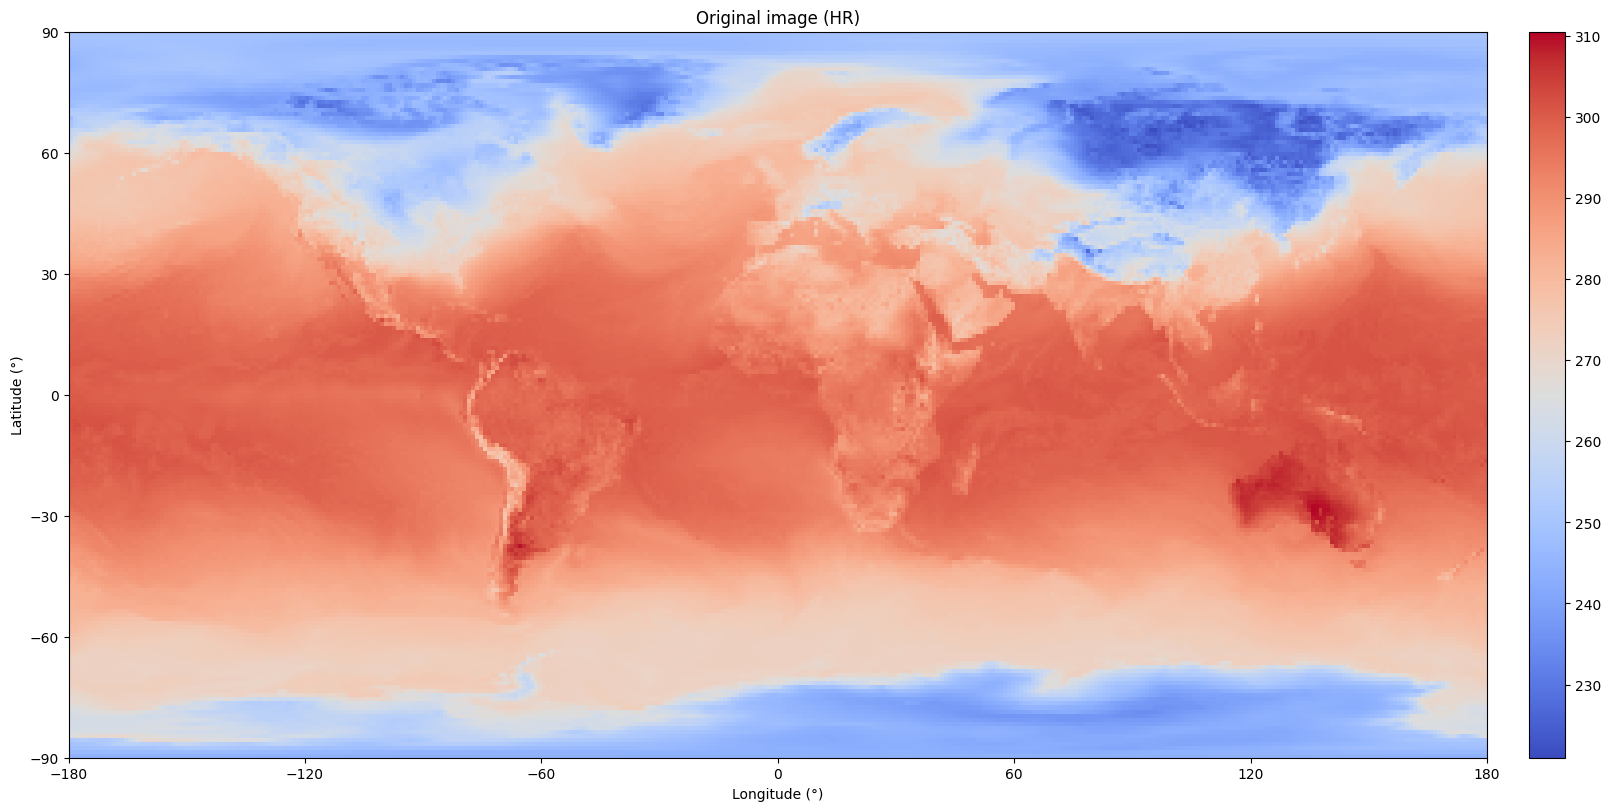

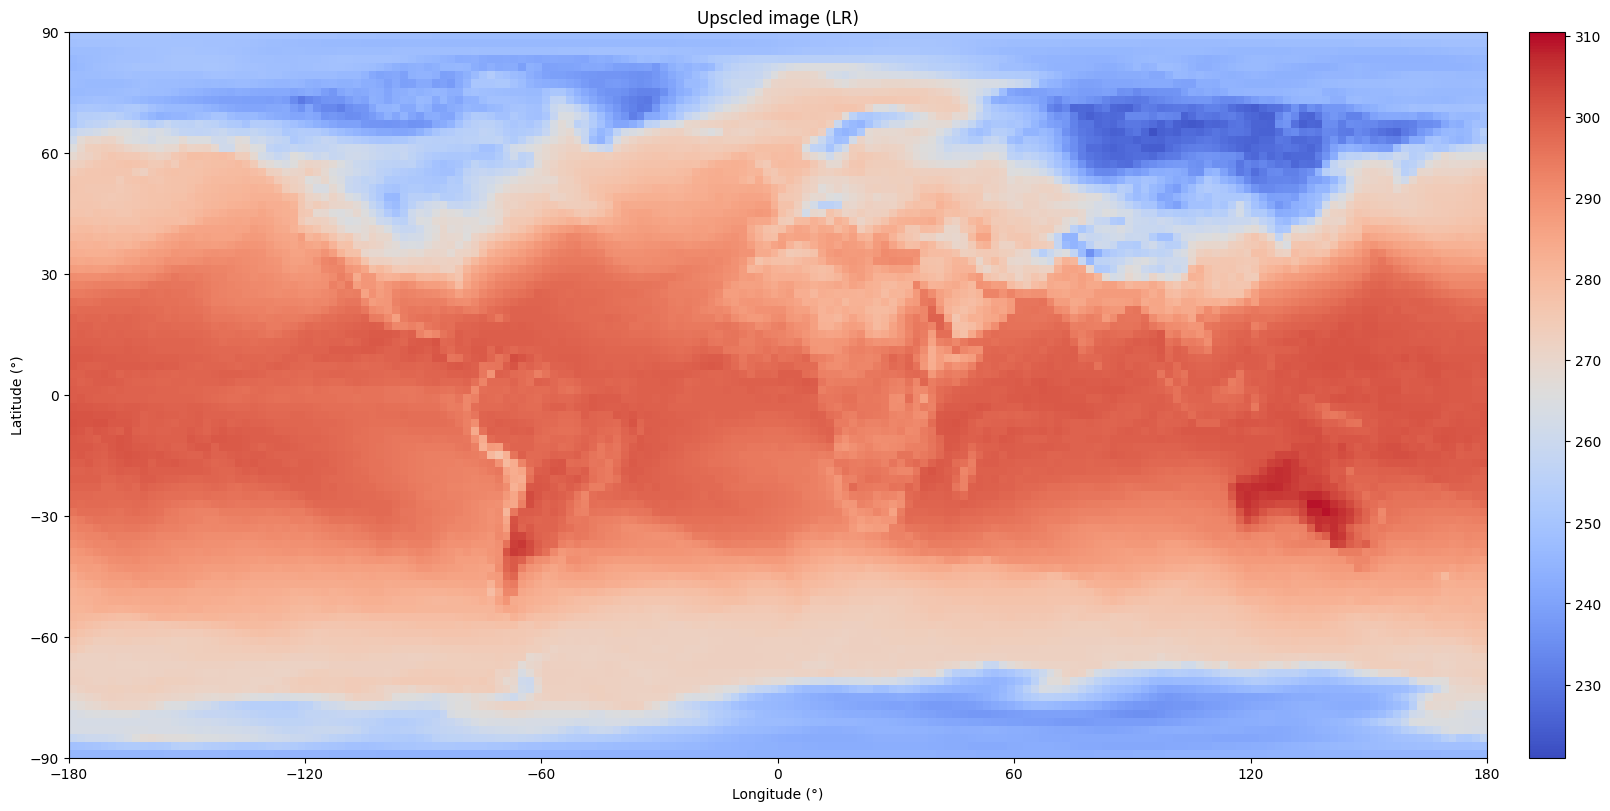

In [2]:
# 4. If masked values exist, turn to NaN
if np.ma.isMaskedArray(HR):
    HR = HR.filled(np.nan)

# 5. Cast values to float32
HR = HR.astype(np.float32, copy=False)

# 6. Divide into 2x2 blocks
HR_blocks = np.ascontiguousarray(HR).reshape(90, 2, 180, 2)

# 7. Average within each block to get one value
LR_small = np.nanmean(HR_blocks, axis=(1, 3)).astype(np.float32)

# 8. Copy that value to match the resolution of HR
LR = np.repeat(np.repeat((LR_small), 2, axis=0), 2, axis=1).astype(np.float32)

# 9. Find min and max pixel values
min_pixel = min(np.nanmin(HR), np.nanmin(LR))
max_pixel = max(np.nanmax(HR), np.nanmax(LR))

# 10. Define plotter function
def show_map(title, a, height=8):
    a = a.copy()
    a = np.roll(a, a.shape[1] // 2, axis=1)
    a = np.flipud(a)

    h, w = a.shape
    extent = [-180, 180, -90, 90]

    fig, ax = plt.subplots(figsize=(height * (w / h), height), constrained_layout=True)
    im = ax.imshow(
        a, vmin=min_pixel, vmax=max_pixel, cmap="coolwarm",
        extent=extent, origin="upper", aspect="auto",
        interpolation="nearest"
    )
    ax.set_title(title)
    ax.set_xlabel("Longitude (°)")
    ax.set_ylabel("Latitude (°)")
    ax.set_xticks(np.arange(-180, 181, 60))
    ax.set_yticks(np.arange(-90, 91, 30))
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
    plt.show()

# 11. Plot
show_map("Original image (HR)", HR)
show_map("Upscled image (LR)", LR)